<strong>Importa librerias a utilizar</strong>

In [ ]:
# -- Utilizar PYTHON 3.11
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import shutil
from PIL import Image

: 

<strong>Redimensionar imagenes a 224x224</strong>

In [ ]:
def redimensiona_imagen(image_path:str) -> None:
    '''
    Carga una imagen y cambia sus dimensiones
    '''
    
    # Abre la imagen
    imagen = Image.open(image_path)

    # -- Definir anchura y altura a aplicar
    width = height = 224

    # Redimensiona la imagen
    imagen = imagen.resize((width, height), Image.LANCZOS)

    # Sobreescribe la imagen con las nuevas dimensiones
    imagen.save(image_path)

In [3]:
directorios = ["train_altogrado", "train_ascus", "train_bajogrado", "train_benigna", "test_altogrado", "test_ascus", "test_bajogrado", "test_benigna"]

for _dir in directorios:
    #Establecemos el directorio base
    directorio = f"{os.getcwd()}\\" + _dir

    # Obtenemos todos los archivos presentes en el directorio
    archivos_jpg = glob.glob(os.path.join(directorio, '*.jpg'))
    archivos_jpeg = glob.glob(os.path.join(directorio, '*.jpeg'))
    archivos_png = glob.glob(os.path.join(directorio, '*.png'))
    archivos_tiff = glob.glob(os.path.join(directorio, '*.tiff'))

    #-- Concatenamos los resultados
    archivos = archivos_jpg + archivos_jpeg + archivos_png + archivos_tiff
    
    for f in archivos:
        redimensiona_imagen(f)

<strong>Obtener la carpeta con menor cantidad de imagenes</strong>

In [4]:
directorios = ["train_altogrado", "train_ascus", "train_bajogrado", "train_benigna"]
totales = []

# -- Obtenemos el total de caracteres maximo del nombre de las rutas para hacer un formateo
longitud_maxima = max(len(d) for d in directorios)

for show_folder in directorios:
    totales.append(len(os.listdir(show_folder)))

    # -- Mostramos el texto formateado a la misma longitud de cadena
    print(f'{show_folder.ljust(longitud_maxima)} \t-> {totales[-1]}')

MENOR = min(totales)
print(f"Reduciremos el total de imagenes a {MENOR}")

train_altogrado 	-> 389
train_ascus     	-> 293
train_bajogrado 	-> 182
train_benigna   	-> 879
Reduciremos el total de imagenes a 182


<strong>Asegura que los datasets tengan la misma cantidad de imagenes</strong>

In [5]:
source_folders = [("./train_altogrado", "./dataset/altogrado"), ("./train_ascus", "./dataset/ascus"), ("./train_bajogrado", "./dataset/bajogrado"), ("./train_benigna","./dataset/benigna")]

for sf in source_folders:
    carpeta_fuente = sf[0]
    carpeta_destino = sf[1]

    # Si no existe la carpeta de destino entonces la creamos
    os.makedirs(carpeta_destino, exist_ok=True)

    sf_images = os.listdir(carpeta_fuente)
    for i, image_name in enumerate(sf_images):

        # -- Limita el total de imagenes a utilizar de acuerdo a la carpeta con menor numero de imagenes
        if i < MENOR:
            shutil.copy('./'+carpeta_fuente + '/' + image_name, './'+carpeta_destino + '/' + image_name)


<h1>pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0</h1>

<strong>Aplicamos transformaciones aleaotorias a nuestro set de datos tambien llamado aumento de datos</strong>

Found 584 images belonging to 4 classes.
Found 144 images belonging to 4 classes.


c:\Users\ingjo\OneDrive\Desktop\cnn\v311\Lib\site-packages\keras\src\preprocessing\image.py:202: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn(


{'altogrado': 0, 'ascus': 1, 'bajogrado': 2, 'benigna': 3} BATCHES = 19
{'altogrado': 0, 'ascus': 1, 'bajogrado': 2, 'benigna': 3} BATCHES = 5


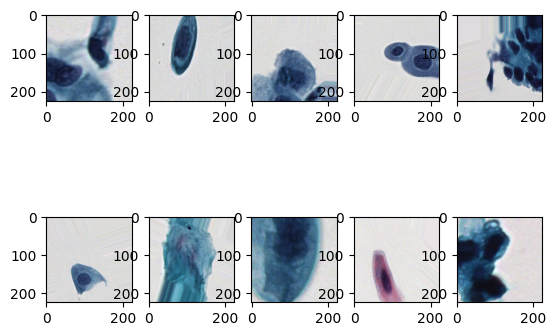

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# -- Crea el dataset generador
datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, width_shift_range=0.25, height_shift_range=0.25, shear_range=15,  zoom_range=[0.5, 1.5], validation_split=0.2)

# -- Crear el set de datos y pruebas

data_gen_entrenamiento = datagen.flow_from_directory(
                                                    './dataset/',
                                                    target_size = (224, 224),
                                                    batch_size=32,
                                                    shuffle=True,
                                                    subset='training' # 80% de los datos .. el campo subset solo puede ser training o validation
                                                    )
data_gen_pruebas = datagen.flow_from_directory(
                                                    './dataset/',
                                                    target_size = (224, 224),
                                                    batch_size=32,
                                                    shuffle=True,
                                                    subset='validation' # 20% de los datos .. el campo subset solo puede ser training o validation
                                                    )

#  el batch = 32, significa que cada iteración de la generación de datos procesará 32 imágenes a la vez.

print(data_gen_entrenamiento.class_indices , f'BATCHES = {len(data_gen_entrenamiento)}')
print(data_gen_pruebas.class_indices, f'BATCHES = {len(data_gen_pruebas)}')   

# -- Imprimir algunas imagenes de entrenamiento
for image, label in data_gen_entrenamiento:
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.xticks()
        plt.yticks()
        plt.imshow(image[i])
    break
plt.show()

<strong> Utilizar el modelo</strong>

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

# Cargar el modelo preentrenado de MobileNetV2 desde TensorFlow Hub
url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobile_net_v2 = hub.KerasLayer(url, input_shape=(224, 224, 3), trainable=False)

# -- INPUT SHAPE es la forma de entrada que espera el modelo, en este caso 224x224x3

# Definir el modelo secuencial
modelo = tf.keras.Sequential([
    mobile_net_v2,
    tf.keras.layers.Dense(4, activation="softmax")
])

# Construir el modelo con la forma de entrada esperada
# El None en este caso indica que puede recibir cualquier cantidad de imagenes
modelo.build((None, 224, 224, 3))

<strong>Resumen del modelo</strong>

In [56]:
modelo.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_2 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2263108 (8.63 MB)
Trainable params: 2228996 (8.50 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


<strong>Compilación del modelo</strong>

In [57]:
modelo.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

<strong>Entrenar el modelo</strong>

In [58]:
EPOCHS = 10
historial = modelo.fit(
    data_gen_entrenamiento,
    epochs=EPOCHS,
    batch_size=32,
    validation_data=data_gen_pruebas
)

Epoch 1/10
19/19 [==============================] - 69s 3s/step - loss: 1.5538 - accuracy: 0.3990 - val_loss: 3.3182 - val_accuracy: 0.3472
Epoch 2/10
19/19 [==============================] - 45s 2s/step - loss: 1.1590 - accuracy: 0.5531 - val_loss: 3.5135 - val_accuracy: 0.4375
Epoch 3/10
19/19 [==============================] - 46s 2s/step - loss: 1.0955 - accuracy: 0.5634 - val_loss: 3.0448 - val_accuracy: 0.4167
Epoch 4/10
19/19 [==============================] - 46s 2s/step - loss: 0.9924 - accuracy: 0.6079 - val_loss: 2.5247 - val_accuracy: 0.3542
Epoch 5/10
19/19 [==============================] - 46s 2s/step - loss: 0.9885 - accuracy: 0.6216 - val_loss: 2.9988 - val_accuracy: 0.4236
Epoch 6/10
19/19 [==============================] - 45s 2s/step - loss: 0.9314 - accuracy: 0.6610 - val_loss: 2.8005 - val_accuracy: 0.3333
Epoch 7/10
19/19 [==============================] - 43s 2s/step - loss: 0.9138 - accuracy: 0.6798 - val_loss: 2.5047 - val_accuracy: 0.3681
Epoch 8/10
19/19 [==

<strong>Graficas de precisión</strong>

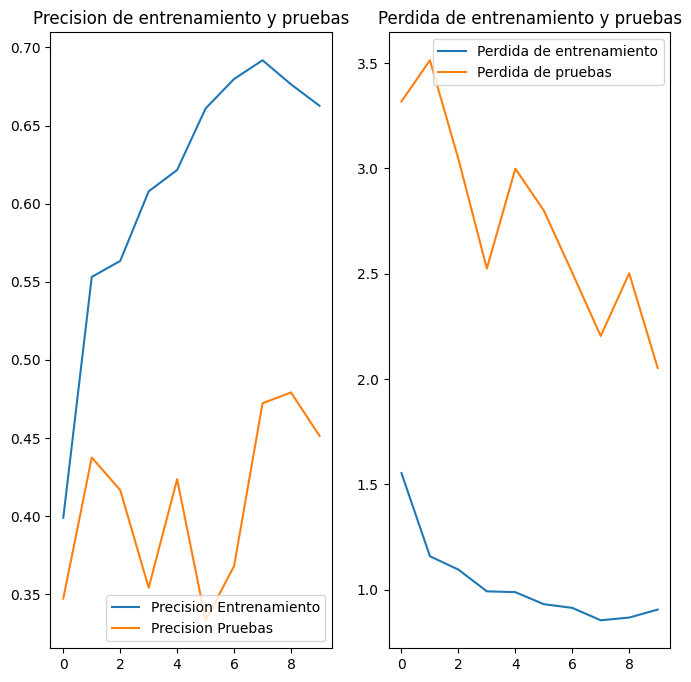

In [59]:
acc = historial.history['accuracy']
val_acc = historial.history['val_accuracy']

loss = historial.history['loss']
val_loss = historial.history['val_loss']

rango_epocas = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc, label="Precision Entrenamiento")
plt.plot(rango_epocas, val_acc, label="Precision Pruebas")
plt.legend(loc="lower right")
plt.title("Precision de entrenamiento y pruebas")

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label="Perdida de entrenamiento")
plt.plot(rango_epocas, val_loss, label="Perdida de pruebas")
plt.legend(loc="upper right")
plt.title("Perdida de entrenamiento y pruebas")

plt.show()

<strong>Categorizador online</strong>

In [60]:
import requests
from io import BytesIO
import cv2

def categorizador(url:str):
    res = requests.get(url)
    img = Image.open(BytesIO(res.content))
    img = np.array(img).astype(float)/255

    img = cv2.resize(img, (224,224))
    prediccion = modelo.predict(img.reshape(-1, 224, 224, 3))
    print(prediccion)
    return np.argmax(prediccion[0], axis=-1)

def categorizador_local(path:str):
    img = Image.open(path)
    img = np.array(img).astype(float)/255

    img = cv2.resize(img, (224,224))
    prediccion = modelo.predict(img.reshape(-1, 224, 224, 3))

    print(prediccion)
    return np.argmax(prediccion[0], axis=-1)



<strong>Ver indices de las categorias</strong>

In [61]:
print(data_gen_entrenamiento.class_indices)
print(data_gen_pruebas.class_indices)

{'altogrado': 0, 'ascus': 1, 'bajogrado': 2, 'benigna': 3}
{'altogrado': 0, 'ascus': 1, 'bajogrado': 2, 'benigna': 3}


In [63]:
predictor = {v:k for k,v in data_gen_entrenamiento.class_indices.items()}
print(predictor)

url = ""
url = './train_ascus/ascus.00058.tiff'

if "http" in url:
    prediccion = categorizador(url)
else:
    prediccion = categorizador_local(url)

print(f'\nEsta celula corresponde a la categoria -> {predictor[prediccion].upper()}')

{0: 'altogrado', 1: 'ascus', 2: 'bajogrado', 3: 'benigna'}
1/1 [==============================] - 0s 53ms/step
[[0.00600739 0.03120326 0.00333207 0.9594573 ]]

Esta celula corresponde a la categoria -> BENIGNA
